In [33]:
import os
import torch
import wandb
import sys
import torch.optim as optim
import random
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime # 시간 출력
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
from torchinfo import summary # 모델 구조 출력용 라이브러리

import warnings # 파이토치의 vram 경고 무시
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.lazy")

In [34]:
BASE_PATH = str(Path.cwd().resolve()) # 현재 작업 디렉토리의 경로를 가져옴
print(BASE_PATH) # DL 파일 경로

sys.path.append(BASE_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") # GPU가 정상적으로 작동하는지 확인

/home/work/DL
Using device: cuda


In [35]:
# 1번 문제. 정확한 MEAN 값과 STD 값을 찾기 위해 추가한 함수

def calculate_mean_std(dataset):
    data_loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    mean = 0.0  # 평균
    std = 0.0  # 표준편차
    total_samples = 0  #

    for data, _ in data_loader:  # 데이터셋에서 배치 단위로 데이터를 가져옴
        batch_samples = data.size(0)  # 현재 배치의 샘플 수
        data = data.view(batch_samples, -1)  # 이미지를 1D 벡터로 변환 ((28,28) =>> 784)

        mean += data.mean(1).sum().item()  # 현재 배치의 평균을 계산하고 누적
        std += data.std(1).sum().item()  # 현재 배치의 표준편차를 계산하고 누적
        total_samples += batch_samples  # 총 샘플 수 누적

    mean /= total_samples  # 총 샘플 수로 평균 계산
    std /= total_samples  # 총 샘플 수로 표준편차 계산

    return mean, std  # 최종 계산된 평균과 표준편차 반환

# FashionMNIST 데이터셋 로드
data_path = "./j_fashion_mnist"  # 데이터셋 경로
f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

# 위에 만든 함수를 통해 FashionMNIST 평균(mean)과 표준편차(std) 계산
mean, std = calculate_mean_std(f_mnist_train)

# 결과 출력
print(f"Mean: {mean}") # 0.286으로 사용
print(f"Std: {std}") # 0.320으로 사용

Mean: 0.28604060643513995
Std: 0.3204533660888672


In [36]:
"""
FashionMNIST 데이터셋을 로드하고, TRAIN 과 VAL 데이터로 나눔.
데이터 로더를 생성하고 반환함.
"""

def get_fashion_mnist_data():
    data_path = "./data/j_fashion_mnist" # 데이터 위치
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # ResNet 구조에 맞게 이미지 크기 조정
        transforms.ToTensor(), # 이미지를 PyTorch 텐서로 변환
        
        #순서를 조금 바꿔 TRAIN, VALDATION 정규화
        transforms.Normalize(mean=0.286, std=0.320), # 구한 값으로 정규화
    ])
    
    #학습 데이터셋 로드 및 변환까지
    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    
    
    #TRAIN과 VALIDATION으로 나눔
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    #총 데이터 출력 55000과 5000
    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    
    
    # 데이터 로더 생성
    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=64, shuffle=True, pin_memory=True, num_workers=2
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=64, shuffle=False, pin_memory=True, num_workers=2
    )
    
    #반환
    return train_data_loader, validation_data_loader

In [37]:
#위의 함수와 동일. 

def get_fashion_mnist_test_data():
    data_path = "./data/j_fashion_mnist"
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.320)
    ])
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
    print("Num Test Samples: ", len(f_mnist_test))

    test_data_loader = DataLoader(
        dataset=f_mnist_test, batch_size=64, shuffle=False, pin_memory=True, num_workers=2
    )

    return f_mnist_test, test_data_loader

In [38]:
# Fashion MNIST 클래스 라벨 정의
# 마지막 TEST 10개 출력에 사용
class_labels = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# ResNet 모델을 생성하는 함수# ResNet 모델을 생성하는 함수


def get_resnet_model():
    class Residual(nn.Module):
        """
        ResNet의 Residual 블록 정의.
        두 개의 컨볼루션 계층과 Batch Normalization을 포함하며,
        선택적으로 1x1 합성곱을 사용해 차원을 맞춤.
        교수님의 RESNET 이용.
        """
        def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1, dropout=0.5):
            super().__init__()
            # 첫 번째 합성곱 계층
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
            self.bn1 = nn.BatchNorm2d(out_channels)
            # 두 번째 합성곱 계층
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
            # 활성화 함수와 드롭아웃
            self.relu = nn.ReLU(inplace=True)
            self.dropout = nn.Dropout(dropout)
            # 1x1 합성곱 (선택적으로 차원을 맞춤)
            if use_1x1conv:
                self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
                self.bn3 = nn.BatchNorm2d(out_channels)
            else:
                self.conv3 = None

        def forward(self, X):
            """
            Residual 블록의 forward pass
            입력 X를 두 개의 합성곱 계층을 통해 처리하고,
            입력과 결과를 더한 후 relu 함수를 적용.
            """
            Y = self.relu(self.bn1(self.conv1(X)))
            Y = self.dropout(Y)
            Y = self.bn2(self.conv2(Y))
            
            if self.conv3:
                X = self.bn3(self.conv3(X))
                
            # Residual 연결 중요!
            Y += X
            
            return self.relu(Y)

    """
    ResNet 모델 정의.
    초기 합성곱 계층, Residual 블록 계층, 풀링 층 포함 및 출력 계층 포함.
    """
    class ResNet(nn.Module):
        def __init__(self, arch, in_channels=1, n_outputs=10):
            super(ResNet, self).__init__()
            
            # 초기 합성곱 계층
            self.model = nn.Sequential(
                nn.Sequential(
                    nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                )
            )
            
            # Residual 블록을 추가
            current_channels = 64
            
            for i, (num_residuals, out_channels) in enumerate(arch):
                self.model.add_module(
                    name=f'block_{i}', # 블록 이름 지정
                    module=self.block(num_residuals, current_channels, out_channels, first_block=(i == 0))
                )
                current_channels = out_channels # 출력 채널 업데이트
            
            # 마지막 계층 (풀링 & 드롭아웃 & Fully Connected)
            self.model.add_module(
                name='last',
                module=nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)), # 평균 풀링 값 하나로
                    nn.Flatten(), # 텐서를 플래튼, 펼침
                    nn.Dropout(0.5), # 드롭아웃 확률 0.5로
                    nn.Linear(current_channels, n_outputs) # fcn
                )
            )

        """
        Residual 블록을 생성.
        첫 블록이 아니면, 1x1 합성곱을 사용해 차원을 맞춤.
        """
        def block(self, num_residuals, in_channels, out_channels, first_block=False):
            blk = []
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
                else:
                    blk.append(Residual(out_channels, out_channels))
            return nn.Sequential(*blk)

        def forward(self, x): # forward pass
            x = self.model(x)
            return x

    my_model = ResNet(
        arch=((3, 64), (4, 128), (6, 256), (3, 512)),  # Residual block 구성
        in_channels=1,  # 입력 채널 (흑백 이미지이기때문에 1)
        n_outputs=10    # 출력 클래스 수 (셔츠 ~~)
    )

    return my_model

In [39]:
"""
테스트 데이터셋을 사용하여 모델을 test.

Args:
    model (nn.Module): 학습시킨 resnet 모델.
    test_loader (DataLoader): 테스트 데이터셋의 데이터 로더.
    device (torch.device): GPU device를 통해 학습.

Returns:
    all_labels (list): 실제 레이블 목록.
    all_preds (list): 모델이 예측한 레이블 목록.
"""

def test_model(model, test_loader, device):
    model.eval() # 모델을 평가 모드로 설정 (Dropout 및 BatchNorm 비활성화)
    correct = 0 # 정확히 예측한 샘플 수 
    total = 0 # 전체 샘플 수

    # 레이블 및 예측 결과 저장용 리스트 초기화
    # 마지막 10개에 표시할 리스트
    all_labels = []
    all_preds = []

    # 테스트 데이터에 대한 평가
    with torch.no_grad(): # 학습 비활성화.
        for images, labels in test_loader: # 데이터 로더에서 배치 단위로 데이터 로드
            images, labels = images.to(device), labels.to(device) # gpu로

            # 모델에 데이터를 전달하여 출력 생성
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # 정확히 예측한 샘플 수를 계산
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # 저장
            all_labels.extend(labels.cpu().numpy()) # 실제 레이블
            all_preds.extend(predicted.cpu().numpy()) # 예측 레이블

    # test 모델의 정확도 계산
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # 실제 레이블 및 예측 레이블 반환
    return all_labels, all_preds

In [40]:
"""
모델을 train 및 validation 하는 함수.

Args:
    model (nn.Module): resnet 모델을 상속.
    train_loader (DataLoader): 학습 데이터셋의 데이터 로더.
    val_loader (DataLoader): 검증 데이터셋의 데이터 로더.
    epochs (int): 학습 반복 수.
    criterion: 손실 함수 CrossEntropyLoss.
    optimizer: 모델 파라미터를 업데이트할 옵티마이저 Adam 사용.
    device (torch.device): 실행할 디바이스 GPU.
"""

def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    model.to(device) # 모델을 gpu로 이동
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(epochs):
        model.train() # 학습 모드로 전환 Dropout 및 BatchNorm 활성화
        train_loss = 0 # 학습 loss
        correct_train = 0 # 예측 성공
        total_train = 0 # 학습 샘플 총 수 초기화

        # Training
        for images, labels in train_loader: # 데이터를 가져와 gpu로
            images, labels = images.to(device), labels.to(device)
            
            # 모델에 데이터를 전달하여 출력 생성
            outputs = model(images)
            loss = criterion(outputs, labels) # loss 계산

            # 옵티마이저 초기화 후 역전파 및 파라미터 업데이트
            optimizer.zero_grad() # 파이토치 grad 초기화. 안하면 계속 누적됨
            loss.backward() # 그래디언트 계산
            optimizer.step() # 파라미터 업데이트

            # 배치 손실 및 정확도 계산
            train_loss += loss.item() # 배치 손실 누적
            _, predicted = torch.max(outputs, 1) # 가장 높은 확률의 클래스 하나 예측
            correct_train += (predicted == labels).sum().item()   # 정확히 예측한 샘플 수
            total_train += labels.size(0) # 총 샘플 수

        # 학습 정확도 계산
        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval() # 평가 모드로 전환 Dropout 및 BatchNorm 비활성화
        val_loss = 0 # train과 유사
        correct_val = 0
        total_val = 0

        with torch.no_grad(): # 그래디언트 계산 비활성화 업데이트하면 안됨.
            #그라디언트 업데이트 이외에 train과 유사
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        
        #그라디언트를 계산하고 업데이트 하는 부분 없음.
        
        # 학습 및 검증 결과를 wandb에 기록
        #문제 2 Training Loss, Validation Loss, Training Accuracy, Validation Accuracy
        wandb.log({
            "Training Loss": train_loss / len(train_loader),
            "Validation Loss": val_loss / len(val_loader),
            "Training Accuracy": train_accuracy,
            "Validation Accuracy": val_accuracy
        })

        # 학습 및 검증 결과 출력
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss / len(train_loader):.4f}, "
            f"Val Loss: {val_loss / len(val_loader):.4f}, "
            f"Train Acc: {train_accuracy:.2f}%, "
            f"Val Acc: {val_accuracy:.2f}%"
        )
        scheduler.step()

In [41]:
"""
문제 4번.
테스트 데이터에서 무작위로 선택된 10개의 샘플에 대해
샘플 테스트 데이터 분류 예측 결과 확인하기.

Args:
    model (nn.Module): resnet 모델.
    test_dataset (Dataset): 테스트 데이터셋.
    device (torch.device): 실행할 디바이스 GPU.
"""

def visualize_predictions(model, test_dataset, device):
    model.eval() # 모델을 평가 모드로 전환 Dropout 및 BatchNorm 비활성화
    
    # 테스트 데이터셋에서 무작위로 10개의 인덱스 선택
    indices = random.sample(range(len(test_dataset)), 10)
    
    # 이미지, 실제 레이블, 예측 레이블을 저장할 리스트 초기화
    images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad(): # 그래디언트 계산 비활성화
        for idx in indices:
            # 선택된 인덱스의 이미지와 레이블 가져오기
            image, label = test_dataset[idx]
            # (C, H, W) -> (H, W)
            images.append(image.squeeze(0).cpu().numpy()) # 시각화를 위해 이미지를 NumPy 배열로 변환
            true_labels.append(label) # 실제 레이블 저장

            # 모델 입력을 위해 배치를 추가한 형태로 변환
            image = image.unsqueeze(0).to(device) # (1, C, H, W)
            output = model(image) # 모델 추론
            _, predicted = torch.max(output, 1)# 가장 높은 확률의 클래스 선택
            predicted_labels.append(predicted.item()) # 예측된 레이블 저장

    # 이미지 출력 및 결과 비교
    for i in range(10):
        plt.figure(figsize=(2, 2))
        plt.imshow(images[i], cmap='gray') # 흑백 이미지 출력
        # 실제 레이블과 예측 레이블 표시
        plt.title(f"Label: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
        plt.axis('off')
        plt.show()

        # 예측 결과 비교
        if true_labels[i] == predicted_labels[i]:
            print(f"Correct Prediction for Image {i+1}")
        else:
            print(f"Incorrect Prediction for Image {i+1}")

Using device: cuda
Num Train Samples:  55000
Num Validation Samples:  5000
Num Test Samples:  10000

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           3,200
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─MaxPool2d: 3-4               [1, 64, 16, 16]           --
│    └─Sequential: 2-2                   [1, 64, 16, 16]           --
│    │    └─Residual: 3-5                [1, 64, 16, 16]           74,112
│    │    └─Residual: 3-6                [1, 64, 16, 16]           74,112
│    │    └─Residual: 3-7                [1, 64, 16, 16]           74,112
│    └─Sequential: 2-3 

Epoch 60/60, Train Loss: 0.0617, Val Loss: 0.1942, Train Acc: 97.75%, Val Acc: 94.12%
Test Accuracy: 93.83%


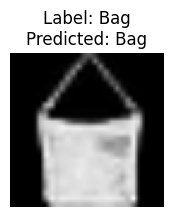

Correct Prediction for Image 1


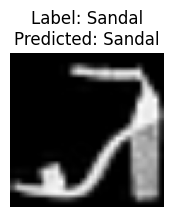

Correct Prediction for Image 2


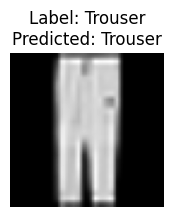

Correct Prediction for Image 3


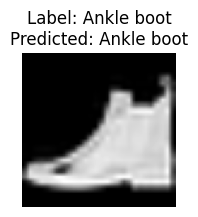

Correct Prediction for Image 4


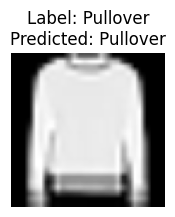

Correct Prediction for Image 5


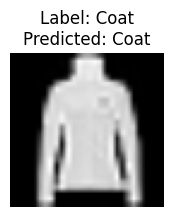

Correct Prediction for Image 6


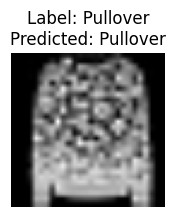

Correct Prediction for Image 7


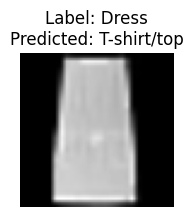

Incorrect Prediction for Image 8


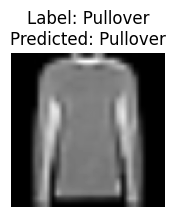

Correct Prediction for Image 9


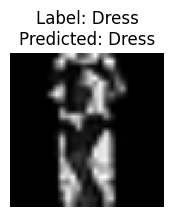

Correct Prediction for Image 10


Training Accuracy,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████████████████
Training Loss,█▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▄▅▆▇▇▇▇███████████████████████████████
Validation Loss,██▇▅▅▃▃▃▅▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Training Accuracy,97.74909
Training Loss,0.0617
Validation Accuracy,94.12
Validation Loss,0.19423


In [44]:
"""
문제 2.
modern cnn 모델 ResNet 이용.
최적화 기법은 Adam, dropout, Weight Decay(L2 정규화)를 추가로 사용.(기본 normalization)
torchinfo를 이용해 모델 구조 출력
"""

#wandb.login(relogin=True)

if __name__ == "__main__":
    # 현재 시간 기록
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 : 배치 수, 학습 반복 수, 학습률, l2 정규화 강도
    config = {'batch_size': 64, 'epochs': 60, 'learning_rate': 0.001, 'weight_decay': 1e-4}
    
    # Weights & Biases(WandB) 설정 및 초기화
    wandb.init(
        mode="online",
        project="fashion-mnist-resnet",
        notes="Fashion MNIST with Custom ResNet and Regularization",
        tags=["ResNet", "FashionMNIST", "Dropout", "Weight Decay"],
        name=current_time_str,
        config=config, # 설정 값 전달
        # settings=wandb.Settings(init_timeout=300)
    )

    # 디바이스 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 데이터 로드
    train_loader, val_loader = get_fashion_mnist_data()
    test_dataset, test_loader = get_fashion_mnist_test_data()

    # 모델 생성
    model = get_resnet_model()
    model.to(device)  # 모델을 GPU 또는 CPU로 전송
    
    # 모델 구조 요약 출력
    print("\nModel Summary:")
    print(summary(
        model,
        input_size=(1, 1, 64, 64),
    ))


    # 손실 함수 및 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    # 학습
    train_model(model, train_loader, val_loader, config['epochs'], criterion, optimizer, device)

    # 테스트
    all_labels, all_preds = test_model(model, test_loader, device)

    # 예측 결과 시각화
    visualize_predictions(model, test_dataset, device=device)

    wandb.finish()


1. 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.001, 'weight_decay': 1e-4
결과 : Validation Accuracy : 93.18% Test Accuracy : 92.33%


2. epochs만 40으로 증가
결과 : Validation Accuracy : 92.56% Test Accuracy : 92.68%
3. epochs만 100으로 증가
결과 : Validation Accuracy : 93.42% Test Accuracy : 92.76%
==> 성능이 오르긴 했지만 가성비가 떨어짐. epoch는 40으로


4. 'batch_size': 64, 'epochs': 40, 'learning_rate': 0.002, 'weight_decay': 1e-4 // learning_rate': 0.002으로 증가
결과 : Validation Accuracy : 92.86% Test Accuracy : 92.39%
5. 'learning_rate': 0.0015
결과 : Validation Accuracy : 90.58% Test Accuracy : 90.36%
==> learning_rate를 건드리니 성능이 떨어짐. learning_rate = 0.001으로 사용


6. Resnet -18 모델을 기반에서 Resnet -34 모델 기반으로 변경
결과 : Validation Accuracy : 93.10% Test Accuracy : 92.67%
==> 성능이 증가함 ResNet-34모델을 기반으로 실행


7. 데이터 증강 (랜덤 수평 뒤집기, 랜덤 회전 추가)
결과 : Validation Accuracy : 92.84% Test Accuracy : 91.17%
==> 성능이 오히러 하락. 제거함


8. 학습률 스케줄링 (학습률 갑소 스케줄링을 사용)
결과 : Validation Accuracy : 93.90% Test Accuracy : 93.70%
==> step 10번마다 *0.1씩 lr을 감소하니 성능이 증가함.

문제 3.
9. 에포크만 60으로 증가
결과 : Validation Accuracy : 94.12% Test Accuracy : 93.83%

문제 4번.

IMAGE 8번에 Dress를 T-shirt/top으로 분류한 것을 볼 수 있는데. 틀린 이미지를 보면 되게 밋밋한데 따라서 특별한 특징이 없어 0.3/0.2/0.4 이런식으로 모델이 예측했을 것 같다.

코딩을 통하여 자신이 취득한 기술적 사항/고찰 내용

ResNet을 구현하며 Skip Connection으로 Gradient가 흐르는 경로를 추가해 모델이 깊어져도 기울기 소멸 문제가 완화되는 것을 경험했다. 왜냐하면 단순한 FCN은 ResNet-34처럼 깊게 쌓으면 성능이 하락했지만, ResNet은 Validation Accuracy까지 상승하며 깊은 네트워크 학습의 가능성을 보여줬다.
1x1 Convolution을 사용해 입력과 출력의 차원을 맞추면서 다양한 채널 크기를 유연하게 처리할 수 있었다.
Epochs를 늘릴수록 Validation과 Test Accuracy가 꾸준히 증가했으나 시간이 많이 소요되었고, 성능 증가 폭이 줄어드는 점에서 가성비가 떨어졌다.
Learning Rate를 조정한 결과 0.001에서 가장 높은 성능을 보였으며, 학습률 스케줄링을 추가하니 성능이 더 향상되었다.
ResNet-18에서 ResNet-34로 교체하니 학습 시간이 더 걸렸지만 표현력이 증가해 Train Accuracy가 97.75%까지 상승하는 성과를 얻었다.
데이터 증강을 추가했으나 성능이 하락했는데, 간단한 수평 뒤집기와 회전 증강이 데이터셋의 패턴을 왜곡했을 가능성을 고려할 때, 데이터 증강 방법의 신중한 설계가 필요함을 느꼈다.

숙제 후기

![불평](./hard.png)
wandb를 public으로 변경하는 방법을 찾지 못해 불편함을 느꼈다. 팀(team)을 설정하지 않으면 프로젝트를 public이나 open으로 설정할 수 있지만, 팀을 설정하지 않으면 프로젝트가 생성되지 않고, 팀을 설정한 후 프로젝트를 만들면 private만 가능하며 팀 멤버끼리만 접근할 수 있어 public으로 바꾸는 방법을 해결하지 못했다.

또한 학습 시간이 매우 오래 걸리는 것을 체감했으며, 특히 CPU에서는 학습이 현실적으로 불가능함을 느꼈다. 엔비디아가 왜 대박났는지 이해가 됬다.

![불평](./hard1.png)

https://wandb.ai/ajhajh503-korea-university-of-technology-and-education/fashion-mnist-resnet?nw=nwuserajhajh503
    